In [9]:
%matplotlib inline
import h5py as hp
import numpy as np
from machine_data import v2366_v2
from FITX import fit_risetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2, v2366_v3, soleil
from matplotlib import rcParams
rcParams['agg.path.chunksize'] = 1000
rcParams['path.simplify_threshold'] = 0.2

In [10]:
ring = v2366_v3()

In [11]:
def get_data(Qp, sc, bunch_current=1.2e-3):
    n_macroparticles = 1e5
    n_turns = 1e5
    n_turns_wake = 50
    Qp_x = Qp
    Qp_y = Qp
    id_state = 'close'
    include_Zlong = 'True'
    harmonic_cavity = 'False'
    # bunch_current = 1.2e-3
    max_kick = 0
    sc = sc
    # folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/mnt/'
    folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/tcbi/'
    
    # folder = '/run/user/30147/gvfs/sftp:host=topaze.ccc.cea.fr,user=gubaiduv/ccc/work/cont003/soleil/gubaiduv/transverse_instabilities/data/raw/tcbi/'
    with hp.File(folder+
                f'monitors(n_mp={n_macroparticles:.1e},'+
                f'n_turns={n_turns:.1e},'+
                f'n_bin=100,bunch_current={bunch_current:.1e},'+
                f'Qp_x={Qp_x:.2f},Qp_y={Qp_y:.2f},ID_state={id_state:},'+
                f'include_Zlong={include_Zlong:},'+
                f'harmonic_cavity={harmonic_cavity:},'+
                f'n_turns_wake={n_turns_wake:},'+
                f'max_kick={max_kick:.1e},'+
                f'sc={sc:}'+
                ').hdf5'
               ) as f:
        print(f.keys())
        print(f['WakePotentialData_0'].keys())
        
        y = f['Beam']['mean'][2, :, :50_000].flatten(order='F')
        yp = f['Beam']['mean'][3, :, :50_000].flatten(order='F')
        Jy = f['Beam']['cs_invariant'][1, :, :].flatten(order='F')
        sig_y = f['Beam']['std'][2, 0 , 0]
        # dip = f['WakePotentialData_0']['dipole_Wydip'][:]
        # prof = f['WakePotentialData_0']['profile_Wydip'][:]
        # tau = f['WakePotentialData_0']['tau_Wydip'][:]
    # y = np.array(y, dtype=np.float64)
    # yp = np.array(yp, dtype=np.float32)
    # Jy = np.array(Jy, dtype=np.float64)
    return y, Jy, sig_y
    # return dip, prof, tau
# y = np.trim_zeros(y)
# yp = np.trim_zeros(yp)

# turns = np.linspace(0, n_turns, y.shape[0])
# fig, ax = plt.subplots(1, 1)

# risetime = plot_offset(ax,
#             m=y,
#             mp=yp,
#             std=sig_y,
#             n_macroparticles=n_macroparticles,
#             n_turns=n_turns,
#             n_bin=100,
#             bunch_current=bunch_current,
#             Qp_x=Qp_x,
#             Qp_y=Qp_y,
#             n_bunches=416,
#             n_sampling = 100)
# dQcoh = 1/(2*np.pi*risetime)
# ring = v2366_v2(IDs=id_state)
# dQrad = 1/(ring.tau[1]*ring.omega0)
# print(f'Threshold current is {500/dQcoh*dQrad:.1f} mA')
# print(f'Synchrotron period in turns {1/(2*np.pi*ring.synchrotron_tune(1.8e6)):.1f}')
# ax.set_xlim(0, 2e4)
# ax.set_ylim(-1e4, 1e4)
# plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/offset(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')

In [12]:
 np.linspace(1.2e-3, 3.6e-3, 13)

array([0.0012, 0.0014, 0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026,
       0.0028, 0.003 , 0.0032, 0.0034, 0.0036])

In [23]:
%%time
chromaticities = [-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
y1, _, sig_y1 = get_data(1.0, 'False', bunch_current=1.2e-3)
y2, _, sig_y2 = get_data(1.0, 'True', bunch_current=1.2e-3)

<KeysViewHDF5 ['Beam', 'WakePotentialData_0']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>
<KeysViewHDF5 ['Beam', 'WakePotentialData_0']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>
CPU times: user 138 ms, sys: 223 ms, total: 361 ms
Wall time: 365 ms


In [24]:
y1.shape

(4160000,)

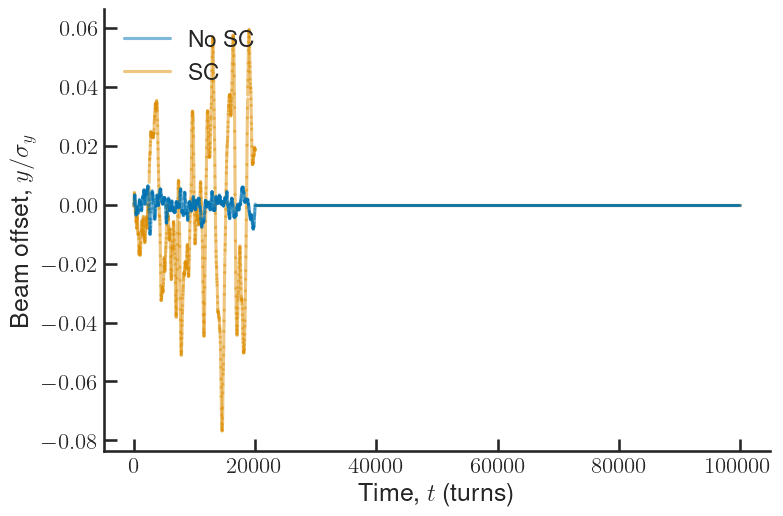

In [25]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
time = np.linspace(0, 10*len(y1)/416, len(y1))
ax.plot(time, y1/sig_y1, alpha=0.5, label='No SC', zorder=3)
ax.plot(time, y2/sig_y1, alpha=0.5, label='SC', zorder=2)
# risetime_1 = .5 * fit_risetime(Jy1, smoothing_window_size=416, matplotlib_axis = None)
# print(f'{risetime_1/416}:.0f')
# risetime_2 = .5* fit_risetime(Jy2, smoothing_window_size=416, matplotlib_axis = None)
# print(f'{risetime_2/416}:.0f')
# # plt.plot(time, y3/sig_y3)
# ax.set_xlim(0, 100_000)
# ax.set_xlim(1e7, )
# ax.set_ylim(-5, 5)
# ax.set_yscale('log')
plt.ylabel('Beam offset, $y/\sigma_y$')
ax.set_xlabel('Time, $t$ (turns)')
plt.legend(loc='upper left')


In [ ]:
currents = 1e-3*np.linspace(1.2e-3, 3.6e-3, 13)
tau = [724, ]
tau_sc = [np.inf, ]

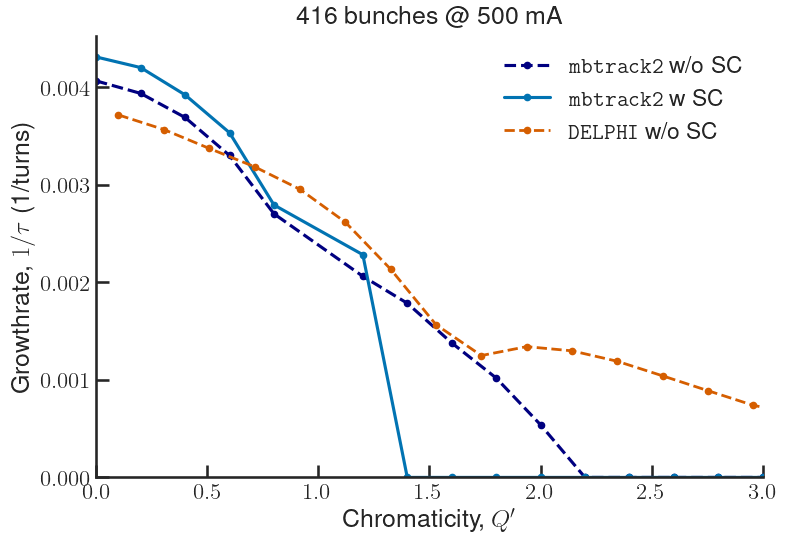

In [3]:
chromaticities = np.array([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0])
tau_nosc = np.array([268, 254, 246, 246, 254, 271, 303, 370, 485, 560, 725, 981, 1854, np.inf, np.inf, np.inf, np.inf, np.inf])
tau_sc = np.array([256, 241, 233, 232, 238, 255, 283, 358, 438, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf ])
plt.plot(chromaticities, 1/tau_nosc, marker='.', color='navy',ls='dashed', label='\\texttt{mbtrack2} w/o SC')
plt.plot(chromaticities, 1/tau_sc, marker='.', color='b',  label='\\texttt{mbtrack2} w SC')
plt.xlim(0, 3.0)
plt.ylim(0, )

sigma_z = 16e-12
Q_s = 1.2e-3
Q_s0 = 2.1e-3
ximp=1.0
damper_gain = 0
id_state = 'close'
plane='vertical'
Ib = 1.2e-3
ring = v2366_v2(IDs=id_state)

filename = f'/home/gubaidulin/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sigma_z:.1e},id={id_state:},plane={plane:},Ib={Ib:.1e},M=416,Q_s={Q_s:.1e},n_max=415,damper_gain={damper_gain:.1e},impedance_multiplier={ximp:.1f}).csv'
df = pd.read_csv(filename, sep='\t')
df = df.drop_duplicates(['chromaticity'])
df = df.dropna(axis=1)
plt.plot(np.array(df['chromaticity'][:]), -np.array(df['eigvals_im'])*(2*np.pi), lw=2, ls='dashed', marker='.', color='r', label="\\texttt{DELPHI} w/o SC")

# plt.axhline(ring.T0*(1/ring.tau[0]+1/ring.tau[2]), ls='dashed')
plt.xlabel("Chromaticity, $Q'$")
plt.ylabel("Growthrate, $1/\\tau$ (1/turns)")
plt.legend(loc='upper right')
plt.title('416 bunches @ 500 mA')
# plt.savefig('../../data/processed/tcbi/space_charge_impact.png')
# plt.savefig('../../data/processed/tcbi/space_charge_impact.pdf')

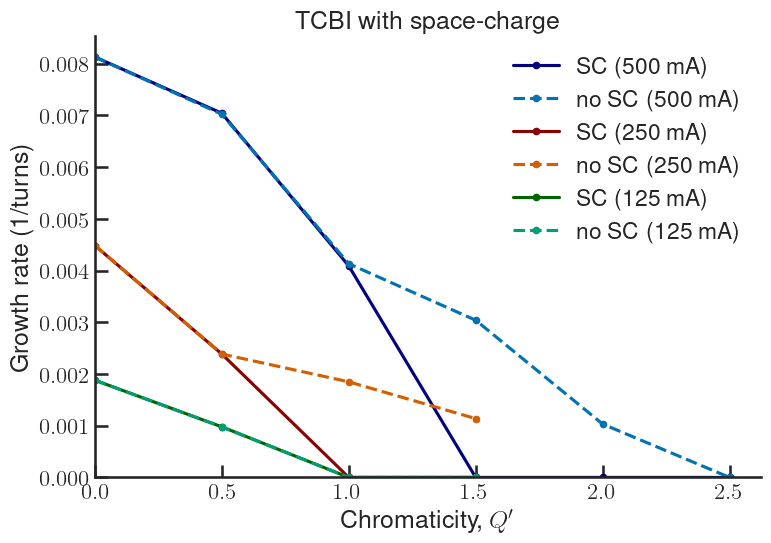

In [76]:
chro = np.array([0, .5, 1.0, 1.5, 2.0, 2.5])
no_sc_500 = 1/(np.array([123, 142.4, 242, 329, 969, np.inf ]))
sc_500 = 1/(np.array([123, 142, 244.5, np.inf, np.inf, np.inf]))

sc_250 = 1/(np.array([223, 419, np.inf, np.inf, ]))
no_sc_250 = 1/(np.array([223, 419, 541, 879, ]))


sc_125 = 1/(np.array([532, 1022, np.inf, np.inf]))
no_sc_125 = 1/(np.array([532,  1022, np.inf, np.inf]))

Q_s0 = 2.0e-3
plt.plot(chro, sc_500, marker='.', color='navy', label='SC (500 mA)')
plt.plot(chro, no_sc_500, marker='.', ls='dashed', color='b', label='no SC (500 mA)')

plt.plot(chro[:4], sc_250, marker='.', color='darkred', label='SC (250 mA)')
plt.plot(chro[:4], no_sc_250, marker='.', ls='dashed', color='r', label='no SC (250 mA)')


plt.plot(chro[:4], sc_125, marker='.', color='darkgreen', label='SC (125 mA)')
plt.plot(chro[:4], no_sc_125, marker='.', ls='dashed', color='g', label='no SC (125 mA)')

plt.xlabel("Chromaticity, $Q'$")
plt.ylabel("Growth rate (1/turns)")
plt.legend(loc = 'upper right')
plt.title('TCBI with space-charge')
plt.ylim(0, )
plt.xlim(0, )
plt.savefig('../../data/processed/tcbi/tcbi_chromaticity_space_charge.png')

/tmp/ipykernel_19255/430958686.py:6: RuntimeWarning: invalid value encountered in divide
  ax.plot(time, y/sig_y, label=labels[i])
/tmp/ipykernel_19255/430958686.py:7: RuntimeWarning: invalid value encountered in divide
  rx = fit_risetime(Jy/sig_y, min_level=1e-4, matplotlib_axis=None)


nan


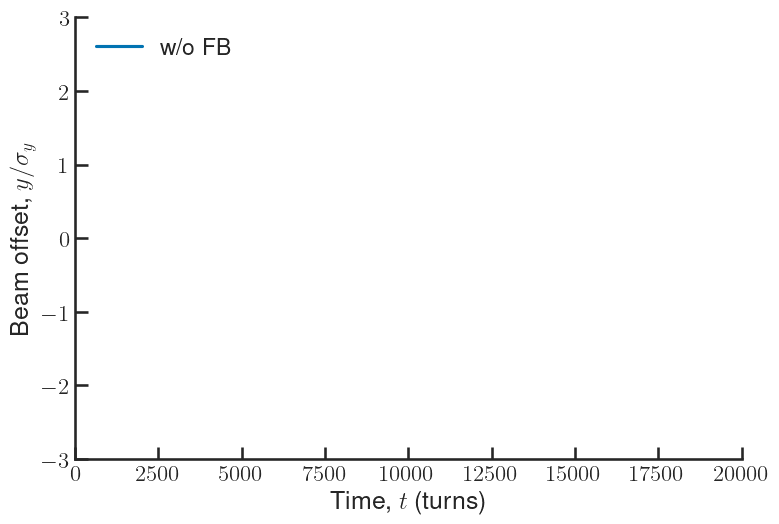

In [4]:

# Jy = np.trim_zeros(Jy)
time = np.linspace(0, len(Jy)/416, len(Jy))
fig, ax = plt.subplots(1, 1)
labels=['w/o FB', 'w/ SOLEIL-like FB']
for i, (y, sig_y, Jy) in enumerate([(y1, sig_y1, Jy1)]):
    ax.plot(time, y/sig_y, label=labels[i])
    rx = fit_risetime(Jy/sig_y, min_level=1e-4, matplotlib_axis=None)
    print(rx/416)
ax.legend(loc='upper left')
ax.set_xlim(0, 20_000)
ax.set_ylim(-3, 3)
ax.set_xlabel('Time, $t$ (turns)')
ax.set_ylabel('Beam offset, $y/\sigma_y$')
# ax.title.set_text(f'Risetime {rx/416:.1f}')
ax.title.set_text('')

178.2857142857143

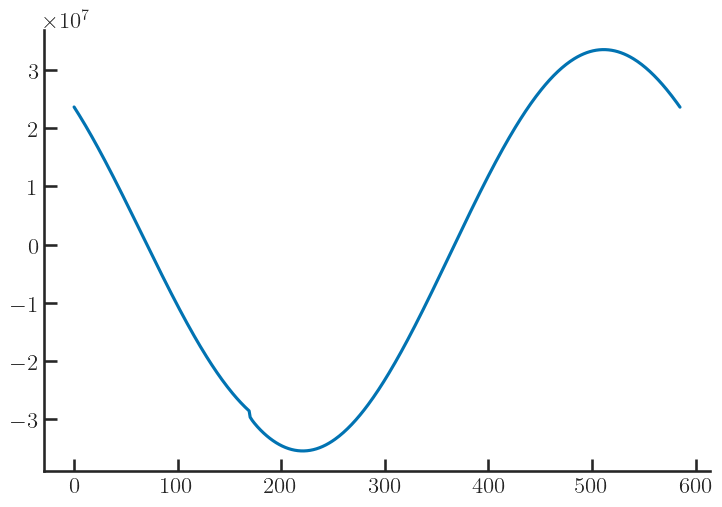

In [24]:
plt.plot(y[-(416+170):]/sig_y)
(1/0.7-1)*416

In [6]:
sample_freq = 416
fft = np.abs(np.fft.rfft(y[:]))
fftfreq = sample_freq*np.fft.rfftfreq(y[:].shape[0])

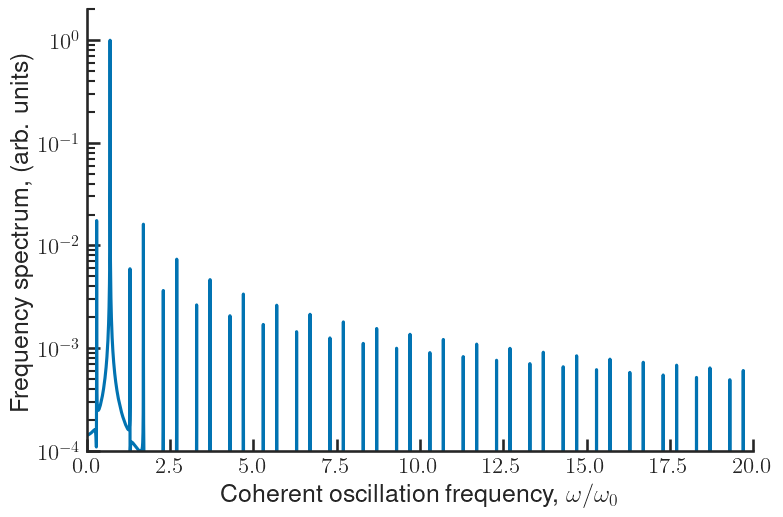

In [7]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(fftfreq, fft/np.max(fft))
ax.set_xlim(0, 20)
ax.set_ylim(1e-4, )
ax.set_xlabel('Coherent oscillation frequency, $\omega/\omega_0$')
ax.set_ylabel('Frequency spectrum, (arb. units)')
plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/spectrum(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')

In [13]:
folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/tcbi/'
filename = 'monitors(n_mp=1.0e+04,n_turns=1.0e+04,n_bin=100,bunch_current=1.2e-03,Qp_x=0.50,Qp_y=0.50,ID_state=close,include_Zlong=True,harmonic_cavity=False,n_turns_wake=50,max_kick=0.0e+00).hdf5'
with hp.File(folder + filename) as f:
    print(f['Beam']['mean'].shape)
    m = f['Beam']['mean'][:]

(6, 416, 10000)


In [9]:
Qp = 1.6
n_macroparticles = 1e5
n_turns = 1e5
n_turns_wake = 50
Qp_x = Qp
Qp_y = Qp
id_state = 'close'
include_Zlong = 'True'
harmonic_cavity = 'False'
bunch_current = 1.2e-3
max_kick = 0
sc = 'True'
folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/mnt/'
with hp.File(folder+
                f'monitors(n_mp={n_macroparticles:.1e},'+
                f'n_turns={n_turns:.1e},'+
                f'n_bin=100,bunch_current={bunch_current:.1e},'+
                f'Qp_x={Qp_x:.2f},Qp_y={Qp_y:.2f},ID_state={id_state:},'+
                f'include_Zlong={include_Zlong:},'+
                f'harmonic_cavity={harmonic_cavity:},'+
                f'n_turns_wake={n_turns_wake:},'+
                f'max_kick={max_kick:.1e},'+
                f'sc={sc:}'+
                ').hdf5') as f:
    print(f.keys())
    print(f['WakePotentialData_0'].keys())
    print(f['Beam']['std'].shape)
    std = f['Beam']['std'][4,0,25_000]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    t = f['WakePotentialData_0']['time'][:]
    
    dip = f['WakePotentialData_0']['dipole_Wydip'][:]
    Wdip = f['WakePotentialData_0']['Wydip'][:]    
    time = f['WakePotentialData_0']['time'][:]

<KeysViewHDF5 ['Beam', 'WakePotentialData_0']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>
(6, 416, 100000)


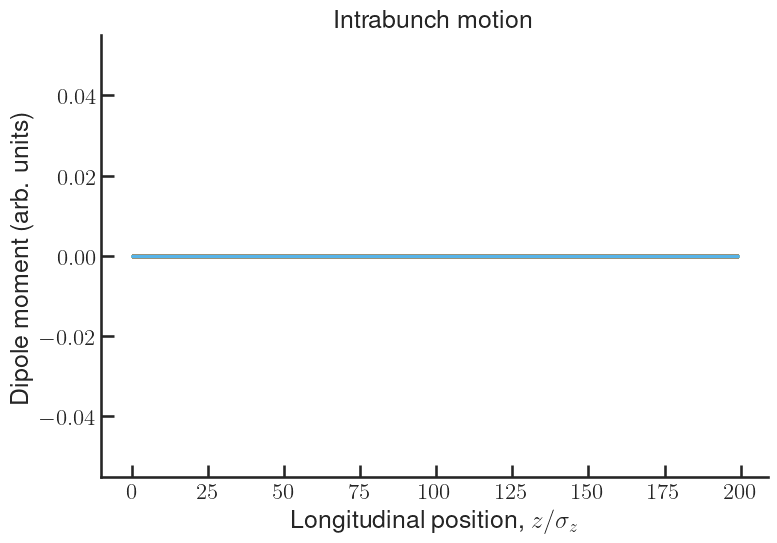

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 0
lineend = 100
# ax.plot(tau[:,linestart:lineend]/std, dip[:,linestart:lineend]*p[:,linestart:lineend],
        # color='black', alpha=0.5)
# ax.set_xlim(-4, 4)
plt.plot(dip)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
# ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
ax.title.set_text('Intrabunch motion')

In [5]:
y, Jy, sig_y = get_data(1.4, 'True', bunch_current=1.2e-3)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/mnt/monitors(n_mp=1.0e+05,n_turns=1.0e+05,n_bin=100,bunch_current=1.2e-03,Qp_x=1.40,Qp_y=1.40,ID_state=close,include_Zlong=True,harmonic_cavity=False,n_turns_wake=50,max_kick=0.0e+00,sc=True).hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
y.shape

NameError: name 'y' is not defined

In [7]:
sample_freq = 416
fft = np.abs(np.fft.rfft(y[:]))
fftfreq = sample_freq*np.fft.rfftfreq(y[:].shape[0])

NameError: name 'y' is not defined

In [17]:
# np.save('fftfreq_tcbi_q1p4_sc',fftfreq)
# np.save('fft_tcbi_q1p4_sc',fft/np.max(fft))

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(fftfreq, fft/np.max(fft))
ax.axvline(1-(ring.tune[1]-np.floor(ring.tune[1])-Q_S),ls='dashed', color='black', label='$1-[Q_y]-Q_s$')
# ax.set_xlim(0., 20)
ax.set_ylim(1e-2, )
ax.set_xlabel('Coherent oscillation frequency, $\omega/\omega_0$')
ax.set_ylabel('Frequency spectrum, (arb. units)')
plt.legend(loc='upper right')

0.0021123164201716322